In [12]:
############# MODULES ################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
np.set_printoptions(threshold=sys.maxsize)

In [4]:
jean_lucs = pd.read_table("jean-lucs_emp_calculations.txt",
                          encoding= "utf_8",
                          encoding_errors= "ignore", # I don't know which encoding to use for '¡' so I will ignore it for now.
                          dtype= {"n shot": int,
                                  "Emp energy inside the chamber (J)": float},
                          decimal= ",") # continental format
jean_lucs = jean_lucs.to_dict(orient= "list")

In [8]:
shots = jean_lucs["n shot"]
requested_data = {"bdot": shots}

emp = cf.read_diagnostic_data(requested_data, function= np.ptp, silent= False)

Found 217 files:
   s04_ALL.csv
   s05_ALL.csv
   s06_ALL.csv
   s07_ALL.csv
   s08_ALL.csv
   s09_ALL.csv
   s10_ALL.csv
   s11_ALL.csv
   s12_ALL.csv
   s13_ALL.csv
   s15_ALL.csv
   S16_ALL.csv
   S17_ALL.csv
   S18_ALL.csv
   S19_ALL.csv
   S20_ALL.csv
   s21_ALL.csv
   s36_ALL.csv
   s37_ALL.csv
   s38_ALL.csv
   s41_ALL.csv
   s42_ALL.csv
   s47_ALL.csv
   s49_ALL.csv
   s34_ALL.csv
   s52_ALL.csv
   s53_ALL.csv
   s60_ALL.csv
   s61_ALL.csv
   s66_ALL.csv
   s67_ALL.csv
   s69_ALL.csv
   s70_ALL.csv
   s71_ALL.csv
   s72_ALL.csv
   s74_ALL.csv
   s75_ALL.csv
   s77_ALL.csv
   s78_ALL.csv
   s79_ALL.csv
   s80_ALL.csv
   s82_ALL.csv
   s83_ALL.csv
   s84_ALL.csv
   s85_ALL.csv
   s86_ALL.csv
   s87_ALL.csv
   s88_ALL.csv
   s89_ALL.csv
   s91_ALL.csv
   s92_ALL.csv
   s93_ALL.csv
   s94_ALL.csv
   s95_ALL.csv
   s96_ALL.csv
   s97_ALL.csv
   s98_ALL.csv
   s100_ALL.csv
   s101_ALL.csv
   s102_ALL.csv
   s103_ALL.csv
   s104_ALL.csv
   S105_ALL.csv
   s106_ALL.csv
   s99_ALL.csv
 

In [9]:
overlapping_shots, count = np.unique([*emp["shot"], *shots], return_counts= True)

overlapping_shots[np.nonzero(count != 2)]

array([234])

In [10]:
emp["shot"].append(234)
emp["bdot"].append(np.nan)

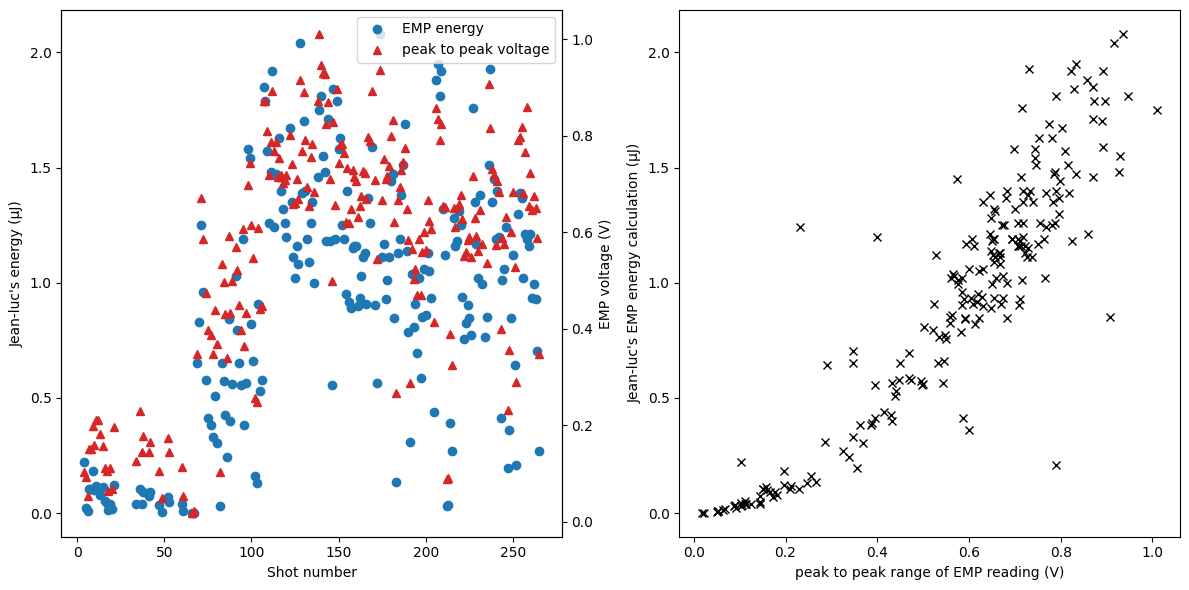

In [13]:
fig, axs = plt.subplots(1, 2, figsize= (12,6))

line1, = axs[0].plot(jean_lucs["n shot"],
                    np.array(jean_lucs["Emp energy inside the chamber (J)"]) *1e6,
                    linestyle= "None",
                    marker= "o",
                    color= "tab:blue",
                    label= "EMP energy")
axs[0].set(xlabel= "Shot number", ylabel= "Jean-luc's energy (μJ)")

twinaxs = axs[0].twinx()
line2, = twinaxs.plot(emp["shot"],
                     emp["bdot"],
                     linestyle= "None",
                     marker= "^",
                     color= "tab:red",
                     label= "peak to peak voltage")
twinaxs.set(ylabel= "EMP voltage (V)")
plt.legend(handles= [line1, line2])



axs[1].plot(emp["bdot"],
         np.array(jean_lucs["Emp energy inside the chamber (J)"]) *1e6,
         linestyle= "None",
         marker= "x",
         color= "k")

axs[1].set(xlabel= "peak to peak range of EMP reading (V)", ylabel= "Jean-luc's EMP energy calculation (μJ)")

plt.tight_layout()
plt.show()